# Audit trails for graph objects in ReGraph (aka versioning)

ReGraph implements a framework for the version control (VC) of graph transformations

The data structure `VersionedGraph` allows to store the history of transformations of a graph object and perform the following VC operations:

- _Rewrite_: perform a rewriting of the object with a commit to the revision history
- _Branch_: create a new branch (with a diverged version of the graph object)
- _Merge branches_: merge branches
- _Rollback_: rollback to a point in the history of transformations

In [14]:
from regraph import NXGraph
from regraph.audit import VersionedGraph
from regraph.rules import Rule
from regraph import print_graph, plot_rule, plot_graph

Create a graph and pass it to the `VersionedGraph` wrapper that will take care of the version control.

In [15]:
graph_obj = NXGraph()
g = VersionedGraph(graph_obj)

Now let's create a rule that adds to the graph two nodes connected with an edge and apply it. If we want the changes to be commited to the version control we rewrite through the `rewrite` method of a `VersioneGraph` object.

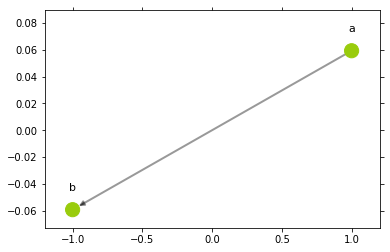

{'a': array([1.        , 0.05931113]), 'b': array([-1.        , -0.05931113])}

In [16]:
rule = Rule.from_transform(NXGraph())
rule.inject_add_node("a")
rule.inject_add_node("b")
rule.inject_add_edge("a", "b")

rhs_instance, _ = g.rewrite(rule, {}, message="Add a -> b")
plot_graph(g.graph)

We create a new branch called "branch"

In [17]:
branch_commit = g.branch("branch")

In [18]:
print("Branches: ", g.branches())
print("Current branch '{}'".format(g.current_branch()))

Branches:  ['master', 'branch']
Current branch 'branch'


Apply a rule that clones the node 'b' to the current vesion of the graph (branch 'branch')

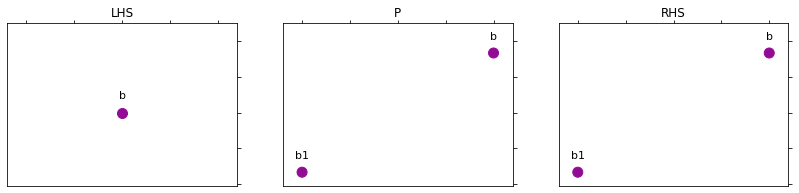

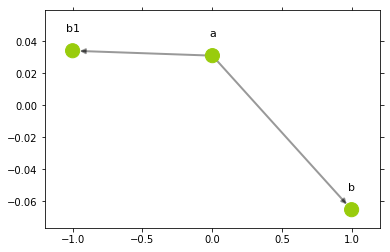

{'a': array([0.00154962, 0.03112121]),
 'b': array([ 0.99845038, -0.06531471]),
 'b1': array([-1.       ,  0.0341935])}

In [19]:
pattern = NXGraph()
pattern.add_node("b")
rule = Rule.from_transform(pattern)
rule.inject_clone_node("b")
plot_rule(rule)

rhs_instance, commit_id = g.rewrite(rule, {"b": rhs_instance["b"]}, message="Clone b")
plot_graph(g.graph)

The `rewrite` method of `VersionedGraph` returns the RHS instance of the applied and the id of the newly created commit corresponding to this rewrite.

In [20]:
print("RHS instance", rhs_instance)
print("Commit ID: ", commit_id)

RHS instance {'b': 'b', 'b1': 'b1'}
Commit ID:  80777e07-1e1c-4dff-9b9e-cd131bd545db


Switch back to the 'master' branch

In [21]:
g.switch_branch("master")
print(g.current_branch())

master


Apply a rule that adds a loop form 'a' to itself, a new node 'c' and connects it with 'a'

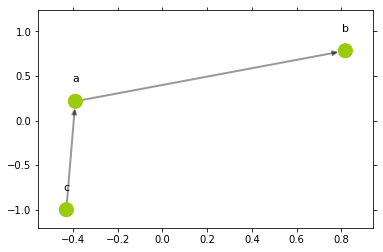

{'a': array([-0.38860792,  0.2164449 ]),
 'b': array([0.81736024, 0.7835551 ]),
 'c': array([-0.42875232, -1.        ])}

In [22]:
pattern = NXGraph()
pattern.add_node("a")
rule = Rule.from_transform(pattern)
rule.inject_add_node("c")
rule.inject_add_edge("c", "a")
rule.inject_add_edge("a", "a")

rhs_instance, _ = g.rewrite(rule, {"a": "a"}, message="Add c and c->a")
plot_graph(g.graph)

Create a new branch 'dev'

In [23]:
g.branch("dev")

'3b6171eb-6bab-4ed4-96ee-a52b9f3f4a50'

In this branch remove an edge from 'c' to 'a' and merge two nodes together

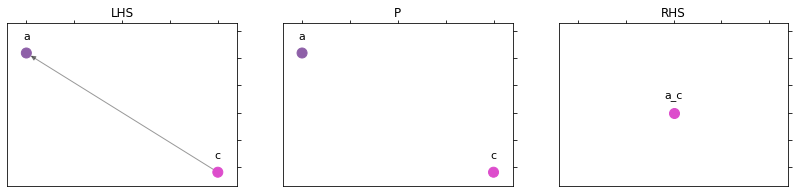

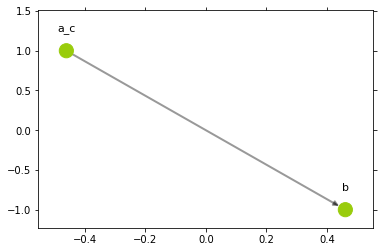

{'b': array([ 0.46132909, -1.        ]),
 'a_c': array([-0.46132909,  1.        ])}

In [24]:
pattern = NXGraph()
pattern.add_node("c")
pattern.add_node("a")
pattern.add_edge("c", "a")
rule = Rule.from_transform(pattern)
rule.inject_remove_edge("c", "a")
rule.inject_merge_nodes(["c", "a"])
plot_rule(rule)

g.rewrite(rule, {"a": rhs_instance["a"], "c": rhs_instance["c"]}, message="Merge c and a")
plot_graph(g.graph)

Switch back to the 'master' branch.

In [25]:
g.switch_branch("master")

Apply a rule that clones a node 'a'

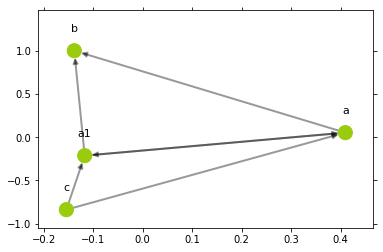

{'b': array([-0.13816919,  1.        ]),
 'c': array([-0.15417514, -0.83881352]),
 'a': array([0.40948225, 0.05255878]),
 'a1': array([-0.11713793, -0.21374526])}

In [26]:
pattern = NXGraph()
pattern.add_node("a")
rule = Rule.from_transform(pattern)
_, rhs_clone = rule.inject_clone_node("a")
rhs_instance, rollback_commit = g.rewrite(rule, {"a": rhs_instance["a"]}, message="Clone a")
plot_graph(g.graph)

Create a new branch 'test'

In [27]:
g.branch("test")

'a3b03ff3-b5ea-420c-aaf5-b32433748ca2'

In this branch apply the rule that adds a new node 'd' and connects it with an edge to one of the cloned 'a' nodes

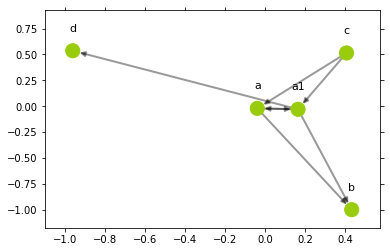

{'b': array([ 0.43216746, -1.        ]),
 'c': array([0.40613904, 0.51467267]),
 'a': array([-0.03984016, -0.02099821]),
 'a1': array([ 0.16383313, -0.0298015 ]),
 'd': array([-0.96229946,  0.53612704])}

In [28]:
pattern = NXGraph()
pattern.add_node("a")
rule = Rule.from_transform(pattern)
rule.inject_add_node("d")
rule.inject_add_edge("a", "d")
g.rewrite(rule, {"a": rhs_instance[rhs_clone]}, message="Add d -> clone of a")
plot_graph(g.graph)

Switch back to 'master'

In [29]:
g.switch_branch("master")

Remove a node 'a'

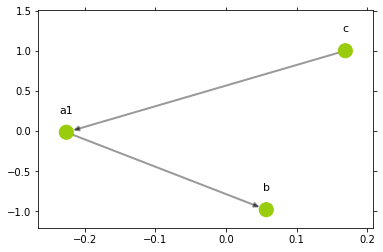

{'b': array([ 0.05704432, -0.98298093]),
 'c': array([0.16908139, 1.        ]),
 'a1': array([-0.2261257 , -0.01701907])}

In [30]:
pattern = NXGraph()
pattern.add_node("a")
rule = Rule.from_transform(pattern)
rule.inject_remove_node("a")
rhs_instance, _ = g.rewrite(rule, {"a": rhs_instance["a"]}, message="Remove a")
plot_graph(g.graph)

Merge the branch 'dev' into 'master'

In [31]:
g.merge_with("dev")

'bed6f2ba-9225-40fc-8279-be3c9b03e8f9'

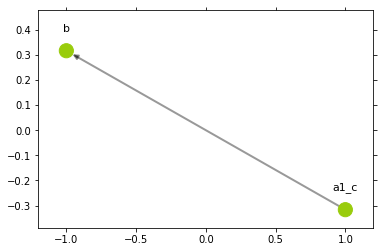

{'b': array([-1.        ,  0.31630693]),
 'a1_c': array([ 1.        , -0.31630693])}

In [32]:
plot_graph(g.graph)

Merge 'test' into 'master'

In [33]:
g.merge_with("test")

'1cf978f2-21d5-41c8-acce-b21360a69c49'

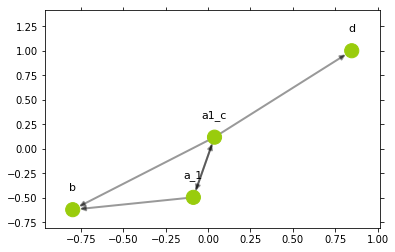

{'b': array([-0.79870706, -0.62190617]),
 'a1_c': array([0.037932  , 0.11800483]),
 'd': array([0.84762519, 1.        ]),
 'a_1': array([-0.08685013, -0.49609866])}

In [34]:
plot_graph(g.graph)

We can inspect the version control object in more details and look at its attribute `_revision_graph`, whose nodes represent the commits and whose edges represent graph deltas between different commits (basically, rewriting rules that constitute commits). Here we can see that on the nodes of the revision graph are stored branch names to which commits belong and user specified commit messages.

In [35]:
for n, attrs in g._revision_graph.nodes(data=True):
    print("Node ID: ", n)
    print("Attributes: ")
    print("\t", attrs)

Node ID:  980d054d-b453-4100-a654-71e9798a6ef9
Attributes: 
	 {'branch': 'master', 'message': 'Initial commit', 'time': datetime.datetime(2020, 3, 30, 15, 52, 51, 437617)}
Node ID:  b9f50cf0-e3f4-4810-b0c6-94a736cf184a
Attributes: 
	 {'branch': 'master', 'time': datetime.datetime(2020, 3, 30, 15, 52, 51, 448243), 'message': 'Add a -> b'}
Node ID:  981504b6-cfce-4fbd-81d8-a285675f8dbb
Attributes: 
	 {'branch': 'branch', 'time': datetime.datetime(2020, 3, 30, 15, 52, 51, 672749), 'message': "Created branch 'branch'"}
Node ID:  80777e07-1e1c-4dff-9b9e-cd131bd545db
Attributes: 
	 {'branch': 'branch', 'time': datetime.datetime(2020, 3, 30, 15, 52, 52, 323102), 'message': 'Clone b'}
Node ID:  299b7e95-eeaa-434c-92da-0b3fa5bfb6ff
Attributes: 
	 {'branch': 'master', 'time': datetime.datetime(2020, 3, 30, 15, 52, 52, 526258), 'message': 'Add c and c->a'}
Node ID:  3b6171eb-6bab-4ed4-96ee-a52b9f3f4a50
Attributes: 
	 {'branch': 'dev', 'time': datetime.datetime(2020, 3, 30, 15, 52, 52, 715075), 'm

In [36]:
# Pretty-print the history
g.print_history()

2020-03-30 15:52:51.437617 980d054d-b453-4100-a654-71e9798a6ef9 master Initial commit
2020-03-30 15:52:51.448243 b9f50cf0-e3f4-4810-b0c6-94a736cf184a master Add a -> b
2020-03-30 15:52:51.672749 981504b6-cfce-4fbd-81d8-a285675f8dbb branch Created branch 'branch'
2020-03-30 15:52:52.323102 80777e07-1e1c-4dff-9b9e-cd131bd545db branch Clone b
2020-03-30 15:52:52.526258 299b7e95-eeaa-434c-92da-0b3fa5bfb6ff master Add c and c->a
2020-03-30 15:52:52.715075 3b6171eb-6bab-4ed4-96ee-a52b9f3f4a50 dev Created branch 'dev'
2020-03-30 15:52:53.384269 63ccf2d3-f9d9-4bf3-97a0-0f0b108a7ba4 dev Merge c and a
2020-03-30 15:52:56.543801 cb70406e-5719-4ce7-812d-0a86077d84a3 master Clone a
2020-03-30 15:53:00.523322 a3b03ff3-b5ea-420c-aaf5-b32433748ca2 test Created branch 'test'
2020-03-30 15:53:02.682316 c3e92bcb-ad44-45be-8444-a93efb56cb0d test Add d -> clone of a
2020-03-30 15:53:06.342396 25cb7a81-44cc-4048-bb93-0ed30fa89158 master Remove a
2020-03-30 15:53:09.397419 bed6f2ba-9225-40fc-8279-be3c9b03e8f

Now we can rollback to some previous commit (commit where we first cloned the node 'a')

In [37]:
g.rollback(rollback_commit)

Created the new head for 'dev'
Created the new head for 'master'


Branches:  ['master', 'branch', 'dev']
Current branch 'master'
Updated revision graph:
2020-03-30 15:52:51.437617 980d054d-b453-4100-a654-71e9798a6ef9 master Initial commit
2020-03-30 15:52:51.448243 b9f50cf0-e3f4-4810-b0c6-94a736cf184a master Add a -> b
2020-03-30 15:52:51.672749 981504b6-cfce-4fbd-81d8-a285675f8dbb branch Created branch 'branch'
2020-03-30 15:52:52.323102 80777e07-1e1c-4dff-9b9e-cd131bd545db branch Clone b
2020-03-30 15:52:52.526258 299b7e95-eeaa-434c-92da-0b3fa5bfb6ff master Add c and c->a
2020-03-30 15:52:52.715075 3b6171eb-6bab-4ed4-96ee-a52b9f3f4a50 dev Created branch 'dev'
2020-03-30 15:52:53.384269 63ccf2d3-f9d9-4bf3-97a0-0f0b108a7ba4 dev Merge c and a
2020-03-30 15:52:56.543801 cb70406e-5719-4ce7-812d-0a86077d84a3 master Clone a
Current graph object


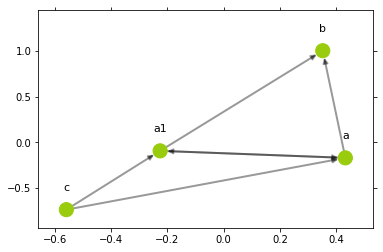


Nodes:

b  :  {}
a1  :  {}
a  :  {}
c  :  {}

Edges:

a1 -> b  :  {}
a1 -> a1  :  {}
a1 -> a  :  {}
a -> a1  :  {}
a -> b  :  {}
a -> a  :  {}
c -> a  :  {}
c -> a1  :  {}


In [38]:
print("Branches: ", g.branches())
print("Current branch '{}'".format(g.current_branch()))
print("Updated revision graph:")
g.print_history()
print("Current graph object")
plot_graph(g.graph)
print_graph(g.graph)

In [39]:
g.switch_branch("branch")

In [40]:
g.rollback(branch_commit)

Created the new head for 'branch'


In [42]:
g.print_history()

2020-03-30 15:52:51.437617 980d054d-b453-4100-a654-71e9798a6ef9 master Initial commit
2020-03-30 15:52:51.448243 b9f50cf0-e3f4-4810-b0c6-94a736cf184a master Add a -> b
2020-03-30 15:52:51.672749 981504b6-cfce-4fbd-81d8-a285675f8dbb branch Created branch 'branch'
2020-03-30 15:52:52.526258 299b7e95-eeaa-434c-92da-0b3fa5bfb6ff master Add c and c->a
2020-03-30 15:52:52.715075 3b6171eb-6bab-4ed4-96ee-a52b9f3f4a50 dev Created branch 'dev'
2020-03-30 15:52:53.384269 63ccf2d3-f9d9-4bf3-97a0-0f0b108a7ba4 dev Merge c and a
2020-03-30 15:52:56.543801 cb70406e-5719-4ce7-812d-0a86077d84a3 master Clone a


In [ ]:
print(g._heads)
plot_graph(g.graph)

In [ ]:
g.switch_branch("master")

In [ ]:
plot_graph(g.graph)

In [ ]:
g.merge_with("branch")

In [ ]:
plot_graph(g.graph)